# Configure font

In [1]:
# Configure Arial as the default font in all figures

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


arial_font_path = '/PATH/TO/ARIAL/FONT/arial.ttf'

fm.fontManager.addfont(arial_font_path)

plt.rcParams['font.family'] = 'Arial'

# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure S20

## Panel A

In [3]:
import pandas as pd
## LOAD ROCKLIN DATA ##

rocklin_query_protein = pd.read_csv(path+'Fig3/FYN_Tsuboyama.txt',sep='\t',index_col=0)

rocklin_query_protein['del']=False
for index, row in rocklin_query_protein.iterrows():
    if len(row['name'].split('_'))>1:
        if row['name'].split('_')[1].startswith('del')==True:
            rocklin_query_protein.at[index,'del']=True
            rocklin_query_protein.at[index,'mutations']=row['name'].split('_')[1][3]+str(int(row['name'].split('_')[1][4:])-1)+'-'

## LOAD THERMOMUT DATA ##

thermomut = pd.read_csv(path+'Fig3/FYN_thermomut.txt',sep='\t', index_col=0)

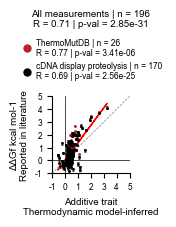

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from matplotlib.lines import Line2D 
import math

plt.rcParams['font.family'] = 'Arial'


coefs = pd.read_csv(path+'Fig6/FYN_suppressor_mochi_order2_sparse_regularized/task_4/weights/weights_Folding.txt', sep='\t')
coefs.rename(columns={'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in coefs.iterrows():
    if row.id_ref =='WT':
        coefs.at[index,'order']=0
    else:
        coefs.at[index,'order']=len(row.id.split('_'))

firstorderterms=coefs.loc[coefs['order']==1].copy()

rocklin_merge = firstorderterms[['id', 'mean', 'std', 'order']].merge(
    rocklin_query_protein.loc[rocklin_query_protein['redundant_single']==False][['mutations', 'deltaG', 'deltaG_95CI']], 
    left_on='id', right_on='mutations'
)
rocklin_merge.set_index('id', inplace=True)
del rocklin_merge['mutations']

rocklins_wt_dg = -1*rocklin_query_protein.loc[rocklin_query_protein['name']=='1A0N.pdb'].iloc[0]['deltaG']
rocklins_wt_dg_SE = (-1*rocklin_query_protein.loc[rocklin_query_protein['name']=='1A0N.pdb'].iloc[0]['deltaG_95CI'])/1.96
alberts_wt_dg = float(coefs.loc[coefs['id']=='WT'].iloc[0]['mean'])
for index, row in rocklin_merge.iterrows():
    variant_dg_SE = (-1*row.deltaG_95CI)/1.96
    variant_ddg_SE = math.sqrt((rocklins_wt_dg_SE**2)+(variant_dg_SE**2))
    rocklin_merge.at[index,'rocklin_dGf'] = -1 *row.deltaG
    rocklin_merge.at[index,'rocklin_ddGf'] = (-1 *row.deltaG) - rocklins_wt_dg
    rocklin_merge.at[index,'rocklin_ddGf_SE'] = variant_ddg_SE
    rocklin_merge.at[index,'rocklin_ddGf_CI95'] = variant_ddg_SE * 1.96
    rocklin_merge.at[index,'albert_dGf'] = alberts_wt_dg + row['mean']
rocklin_avg = pd.DataFrame()
rocklin_merge=rocklin_merge.reset_index()
rocklin_avg["id"] = pd.Series(dtype="object") 
for index, row in rocklin_merge.value_counts('id').to_frame().iterrows():
    multiple_measurements = rocklin_merge.loc[rocklin_merge['id']==index]
    rocklin_avg.at[index,'id']=index
    rocklin_avg.at[index,'mean']=multiple_measurements.iloc[0]['mean']
    rocklin_avg.at[index,'std']=multiple_measurements.iloc[0]['std']
    rocklin_avg.at[index,'Nham']=multiple_measurements.iloc[0]['order']
    rocklin_avg.at[index,'prev_ddG']=multiple_measurements['rocklin_ddGf'].mean()
    rocklin_avg.at[index,'prev_SE']=multiple_measurements['rocklin_ddGf_SE'].mean()
rocklin_merge = rocklin_avg.copy()

# thermomut_merge = rocklin_merge.merge(thermomut.loc[(thermomut['order'] == 1) & (thermomut['ΔΔG'].notna())][['ΔΔG','Mut1','order']], left_on='id',right_on='Mut1').drop_duplicates().set_index('Mut1').sort_values('mean').copy()
thermomut_merge = firstorderterms[['id', 'mean', 'std','order']].merge(thermomut.loc[(thermomut['order'] == 1) & (thermomut['ΔΔG'].notna())][['ΔΔG','Mut1','order']], left_on='id',right_on='Mut1').drop_duplicates().set_index('Mut1').sort_values('mean').copy()
thermomut_avg = pd.DataFrame()
thermomut_avg["id"] = pd.Series(dtype="object") 
for index, row in thermomut_merge.value_counts('id').to_frame().iterrows():
    multiple_measurements = thermomut_merge.loc[thermomut_merge['id']==index]
    thermomut_avg.at[index,'id']=index
    thermomut_avg.at[index,'mean']=multiple_measurements.iloc[0]['mean']
    thermomut_avg.at[index,'std']=multiple_measurements.iloc[0]['std']
    thermomut_avg.at[index,'order_x']=multiple_measurements.iloc[0]['order_x']
    thermomut_avg.at[index,'ΔΔG']=multiple_measurements['ΔΔG'].mean()
    thermomut_avg.at[index,'iv_std']=multiple_measurements['ΔΔG'].std()
thermomut_core = thermomut_avg[['ΔΔG','iv_std','mean','std','order_x']].copy()
thermomut_core = thermomut_core.rename(columns={'ΔΔG':'prev_ddG','iv_std':'prev_SE','order_x':'Nham'})
thermomut_core['Dataset']='ThermoMutDB'
rocklin_merge = rocklin_merge.rename(columns={'rocklin_ddGf':'prev_ddG','rocklin_ddGf_SE':'prev_SE','order':'Nham'})
rocklin_merge['Dataset']='cDNA display proteolysis'
all_core_ddGf_validations = pd.concat([thermomut_core[['prev_ddG','prev_SE','mean','std','Dataset','Nham']],rocklin_merge[['prev_ddG','prev_SE','mean','std','Dataset','Nham']]],axis=0)
## MAKE PLOT ##


fig, ax = plt.subplots(figsize=(1, 1))
palette = {'ThermoMutDB': '#BB202E', 'cDNA display proteolysis': 'black'}
scatter = sns.scatterplot(
    x='mean', 
    y='prev_ddG', 
    data=all_core_ddGf_validations, 
    hue='Dataset', 
    palette=palette, 
    ax=ax, 
    s=0,  # No marker size
    edgecolor='k', 
    linewidth=0.1
)
for dataset in palette.keys():
    plt.errorbar(
        all_core_ddGf_validations.loc[all_core_ddGf_validations['Dataset'] == dataset]['mean'], 
        all_core_ddGf_validations.loc[all_core_ddGf_validations['Dataset'] == dataset]['prev_ddG'], 
        yerr=all_core_ddGf_validations.loc[all_core_ddGf_validations['Dataset'] == dataset]['prev_SE'], 
        xerr=all_core_ddGf_validations.loc[all_core_ddGf_validations['Dataset'] == dataset]['std'], 
        elinewidth=0.3, capsize=1, capthick=0.5, markersize=1, linewidth=0, fmt='o',
        color=palette[dataset], label=''
    )
x = all_core_ddGf_validations[['mean']].to_numpy()
y = all_core_ddGf_validations[['prev_ddG']].to_numpy()
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
plt.plot(x, y_pred, color='red', linewidth=1, linestyle='-')
r, p = pearsonr(y.ravel(), y_pred.ravel())
ax.text(
    0.5,2, 
    f'All measurements | n = {len(x)}\nR = {round(r, 2)} | p-val = {p:.2e}', 
    fontsize=7, color='black', ha='center', va='center', transform=ax.transAxes
)
plt.xlabel('Additive trait\nThermodynamic model-inferred', fontsize=7)
plt.ylabel('ΔΔGf kcal mol-1\nReported in literature', fontsize=7)
ax.set_xticks(np.arange(-1, 6, 1))
ax.set_xticklabels(np.arange(-1, 6, 1), fontsize=6)
ax.set_yticks(np.arange(-1, 6, 1))
ax.set_yticklabels(np.arange(-1, 6, 1), fontsize=6)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim(-0.7,3.5)
ax.axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'gray',lw=0.5)
ax.axvline(0,lw=0.5,color='k')
ax.axhline(0,lw=0.5,color='k')
ax.set_ylim(-1,5)
ax.set_xlim(-1,5)
handles, labels = scatter.get_legend_handles_labels()
legend_labels = []
custom_markers=[]
for dataset in palette.keys():
    subset = all_core_ddGf_validations[all_core_ddGf_validations['Dataset'] == dataset]
    x_subset = subset[['mean']].to_numpy()
    y_subset = subset[['prev_ddG']].to_numpy()
    model.fit(x_subset, y_subset)
    y_pred_subset = model.predict(x_subset)
    r_subset, p_subset = pearsonr(y_subset.ravel(), y_pred_subset.ravel())
    
    legend_labels.append(f"{dataset} | n = {len(x_subset)}\nR = {round(r_subset, 2)} | p-val = {p_subset:.2e}")
    custom_markers.append(Line2D([0], [0], marker='o', color=palette[dataset], markersize=5, linestyle=''))
legend = ax.legend(
    handles=custom_markers, 
    labels=legend_labels, 
    bbox_to_anchor=(0.5, 1.1),
    loc='lower center',
    fontsize=6, 
    frameon=False, 
    handletextpad=0.1, 
    title=''
)
legend.get_title().set_fontsize(7)
legend._legend_box.align = "center"


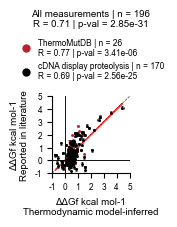

In [5]:
### SCALE VALUES TO MATCH IDENTITY LINE ###

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from matplotlib.lines import Line2D  # For adding custom legend markers
import math

plt.rcParams['font.family'] = 'Arial'


coefs = pd.read_csv(path+'Fig6/FYN_suppressor_mochi_order2_sparse_regularized/task_4/weights/weights_Folding.txt', sep='\t')

coefs.rename(columns={'ci95_kcal/mol': 'ci95_kcal_mol'}, inplace=True)
for index, row in coefs.iterrows():
    if row.id_ref == 'WT':
        coefs.at[index, 'order'] = 0
    else:
        coefs.at[index, 'order'] = len(row.id.split('_'))

firstorderterms = coefs.loc[coefs['order'] == 1].copy()

rocklin_merge = firstorderterms[['id', 'mean', 'std', 'order']].merge(
    rocklin_query_protein.loc[rocklin_query_protein['redundant_single']==False][['mutations', 'deltaG', 'deltaG_95CI']], 
    left_on='id', right_on='mutations'
)
rocklin_merge.set_index('id', inplace=True)
del rocklin_merge['mutations']

rocklins_wt_dg = -1 * rocklin_query_protein.loc[rocklin_query_protein['name'] == '1A0N.pdb'].iloc[0]['deltaG']
rocklins_wt_dg_SE = (-1 * rocklin_query_protein.loc[rocklin_query_protein['name'] == '1A0N.pdb'].iloc[0]['deltaG_95CI']) / 1.96
alberts_wt_dg = float(coefs.loc[coefs['id'] == 'WT'].iloc[0]['mean'])
for index, row in rocklin_merge.iterrows():
    variant_dg_SE = (-1 * row.deltaG_95CI) / 1.96
    variant_ddg_SE = math.sqrt((rocklins_wt_dg_SE**2) + (variant_dg_SE**2))
    rocklin_merge.at[index, 'rocklin_dGf'] = -1 * row.deltaG
    rocklin_merge.at[index, 'rocklin_ddGf'] = (-1 * row.deltaG) - rocklins_wt_dg
    rocklin_merge.at[index, 'rocklin_ddGf_SE'] = variant_ddg_SE
    rocklin_merge.at[index, 'rocklin_ddGf_CI95'] = variant_ddg_SE * 1.96
    rocklin_merge.at[index, 'albert_dGf'] = alberts_wt_dg + row['mean']
rocklin_avg = pd.DataFrame()
rocklin_merge=rocklin_merge.reset_index()
rocklin_avg["id"] = pd.Series(dtype="object") 
for index, row in rocklin_merge.value_counts('id').to_frame().iterrows():
    multiple_measurements = rocklin_merge.loc[rocklin_merge['id']==index]
    rocklin_avg.at[index,'id']=index
    rocklin_avg.at[index,'mean']=multiple_measurements.iloc[0]['mean']
    rocklin_avg.at[index,'std']=multiple_measurements.iloc[0]['std']
    rocklin_avg.at[index,'Nham']=multiple_measurements.iloc[0]['order']
    rocklin_avg.at[index,'prev_ddG']=multiple_measurements['rocklin_ddGf'].mean()
    rocklin_avg.at[index,'prev_SE']=multiple_measurements['rocklin_ddGf_SE'].mean()
rocklin_merge = rocklin_avg.copy()

thermomut_merge = firstorderterms[['id', 'mean', 'std', 'order']].merge(
    thermomut.loc[(thermomut['order'] == 1) & (thermomut['ΔΔG'].notna())][['ΔΔG', 'Mut1', 'order']], 
    left_on='id', right_on='Mut1'
).drop_duplicates().set_index('Mut1').sort_values('mean').copy()
thermomut_avg = pd.DataFrame()
thermomut_avg["id"] = pd.Series(dtype="object") 
for index, row in thermomut_merge.value_counts('id').to_frame().iterrows():
    multiple_measurements = thermomut_merge.loc[thermomut_merge['id']==index]
    thermomut_avg.at[index,'id']=index
    thermomut_avg.at[index,'mean']=multiple_measurements.iloc[0]['mean']
    thermomut_avg.at[index,'std']=multiple_measurements.iloc[0]['std']
    thermomut_avg.at[index,'order_x']=multiple_measurements.iloc[0]['order_x']
    thermomut_avg.at[index,'ΔΔG']=multiple_measurements['ΔΔG'].mean()
    thermomut_avg.at[index,'iv_std']=multiple_measurements['ΔΔG'].std()
thermomut_core = thermomut_avg[['ΔΔG','iv_std','mean','std','order_x']].copy()
thermomut_core = thermomut_core.rename(columns={'ΔΔG':'prev_ddG','iv_std':'prev_SE','order_x':'Nham'})
thermomut_core['Dataset']='ThermoMutDB'
#rocklin_merge = rocklin_merge.rename(columns={'rocklin_ddGf': 'prev_ddG', 'rocklin_ddGf_SE': 'prev_SE', 'order': 'Nham'})
rocklin_merge['Dataset'] = 'cDNA display proteolysis'
all_core_ddGf_validations = pd.concat(
    [thermomut_core[['prev_ddG', 'prev_SE', 'mean', 'std', 'Dataset', 'Nham']],
     rocklin_merge[['prev_ddG', 'prev_SE', 'mean', 'std', 'Dataset', 'Nham']]],
    axis=0
)

## MAKE PLOT ##
fig, ax = plt.subplots(figsize=(1, 1))
palette = {'ThermoMutDB': '#BB202E', 'cDNA display proteolysis': 'black'}

x = all_core_ddGf_validations[['mean']].to_numpy()
y = all_core_ddGf_validations[['prev_ddG']].to_numpy()
model = LinearRegression()
model.fit(x, y)
slope = model.coef_[0][0]
intercept = model.intercept_[0]


y_scaled = y
x_scaled = slope * x + intercept
model_scaled = LinearRegression()
model_scaled.fit(x_scaled, y_scaled)
y_pred_scaled = model_scaled.predict(x_scaled)
scatter=sns.scatterplot(
    x=x_scaled.ravel(),
    y=y_scaled.ravel(),
    hue=all_core_ddGf_validations['Dataset'],
    palette=palette,
    ax=ax,
    s=0,
    edgecolor='k',
    linewidth=0.1
)
for dataset in palette.keys():
    mask = all_core_ddGf_validations['Dataset'] == dataset
    plt.errorbar(
        x_scaled[mask].ravel(), 
        y_scaled[mask].ravel(),
        yerr=all_core_ddGf_validations.loc[mask]['prev_SE'], 
        xerr=all_core_ddGf_validations.loc[mask]['std'] * slope,#(slope if slope > 1 else 1), 
        fmt='o',
        elinewidth=0.3, 
        capsize=1, 
        capthick=0.5, 
        markersize=1,
        linewidth=0, 
        color=palette[dataset], 
        label=''
    )
plt.plot(x_scaled, y_pred_scaled, color='red', linewidth=1, linestyle='-')
ax.axline((0, 0), slope=1, linestyle="dashed", color='gray', lw=0.5)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
r, p = pearsonr(y_scaled.ravel(), y_pred_scaled.ravel())
ax.text(
    0.5,2, 
    f'All measurements | n = {len(x)}\nR = {round(r, 2)} | p-val = {p:.2e}', 
    fontsize=7, color='black', ha='center', va='center', transform=ax.transAxes
)
plt.xlabel('ΔΔGf kcal mol-1\nThermodynamic model-inferred', fontsize=7)
plt.ylabel('ΔΔGf kcal mol-1\nReported in literature', fontsize=7)
ax.set_xticks(np.arange(-1, 6, 1))
ax.set_xticklabels(np.arange(-1, 6, 1), fontsize=6)
ax.set_yticks(np.arange(-1, 6, 1))
ax.set_yticklabels(np.arange(-1, 6, 1), fontsize=6)
ax.spines[['right', 'top']].set_visible(False)
ax.axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'gray',lw=0.5)
ax.axvline(0,lw=0.5,color='k')
ax.axhline(0,lw=0.5,color='k')
ax.set_ylim(-1,5)
ax.set_xlim(-1,5)
handles, labels = scatter.get_legend_handles_labels()
legend_labels = []
custom_markers=[]
for dataset in palette.keys():
    subset = all_core_ddGf_validations[all_core_ddGf_validations['Dataset'] == dataset]
    x_subset = subset[['mean']].to_numpy()
    y_subset = subset[['prev_ddG']].to_numpy()
    
    # Linear regression and correlation for the subset
    model.fit(x_subset, y_subset)
    y_pred_subset = model.predict(x_subset)
    r_subset, p_subset = pearsonr(y_subset.ravel(), y_pred_subset.ravel())
    
    legend_labels.append(f"{dataset} | n = {len(x_subset)}\nR = {round(r_subset, 2)} | p-val = {p_subset:.2e}")
    custom_markers.append(Line2D([0], [0], marker='o', color=palette[dataset], markersize=5, linestyle=''))
    
legend = ax.legend(
    handles=custom_markers,
    labels=legend_labels,
    bbox_to_anchor=(0.5, 1.1),
    loc='lower center',
    fontsize=6,
    frameon=False,
    handletextpad=0.5,
    title='',
    title_fontsize=7
)
legend._legend_box.align = "center"
all_core_ddGf_validations['actual_ddGs']=x_scaled
all_core_ddGf_validations['scaled_std']=all_core_ddGf_validations['std'].to_numpy() * slope
all_core_ddGf_validations.drop_duplicates('actual_ddGs').to_csv(path+'Fig6/FYN_suppressor_ddGs_scaled_from_additivetrait_2ndordersparsemodel.txt',sep='\t')

## Panel B

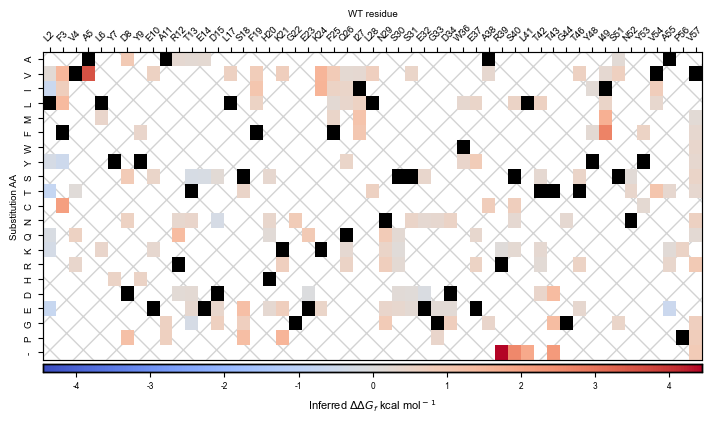

In [6]:
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

firstorderterms=all_core_ddGf_validations.drop_duplicates('actual_ddGs').copy()
firstorderterms["mut_from"] = pd.Series(dtype="object")
firstorderterms["mut_to"] = pd.Series(dtype="object")
for index, row in firstorderterms.iterrows():
    firstorderterms.at[index,'mut_from']=row.name[0:-1]
    firstorderterms.at[index,'mut_to']=row.name[-1]
    if row.name !='WT':
        firstorderterms.at[index,'mut_pos']=int(row.name[1:-1])

firstorderterms=firstorderterms.sort_values('mut_pos',ascending=True)

mutated_positions = list(firstorderterms['mut_from'].unique())


coefs_hm=pd.DataFrame(columns=mutated_positions)

for index, row in firstorderterms.iterrows():
    if row.name !='WT':
        coefs_hm.at[row.mut_to,row.mut_from]=row.actual_ddGs
coefs_hm = coefs_hm.reindex(['A', 'V', 'I', 'L', 'M', 'F', 'W', 'Y', 'S', 'T', 'C', 'N', 'Q', 'K', 'R', 'H', 'D', 'E', 'G', 'P', '-'])
singles_boundary=abs(coefs_hm).fillna(0).to_numpy().max()
fig, ax = plt.subplots(figsize=(8.5,4))
cbar_ax=fig.add_axes([0.125,0.08,0.775,0.02])
ax=sns.heatmap(coefs_hm.fillna(np.nan), mask=coefs_hm.fillna(np.nan).isnull(), cmap='coolwarm', xticklabels=True, yticklabels=True,cbar_kws={"orientation": "horizontal", "pad": 0.02, 'ticks':list(np.arange(-2,3,1))}, cbar_ax=cbar_ax,ax=ax,
              vmax=singles_boundary,vmin=-1*singles_boundary)
ax.set_facecolor('white')
ax.patch.set(hatch='x', edgecolor='#D3D3D3',linewidth=1)
ax.figure.axes[-1].set_xlabel(r'Inferred ${ΔΔG_{f}}$ \ kcal mol$^-$$^1$', rotation=0, labelpad=5, fontsize=7)
ax.tick_params(axis='both', which='both', labelsize=7, labelbottom = False, bottom=False, top = True, labeltop=True)
ax.tick_params(axis='x', which='both', rotation=45)
ax.set_xlabel('WT residue',  fontsize=7)
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Substitution AA', fontsize=7)

cbar_ax.set_xlabel(r'Inferred ${ΔΔG_{f}}$ kcal mol$^-$$^1$', rotation=0, fontsize=8)
cbar_ax.xaxis.set_label_position('bottom')
cbar_ax.set_xticks(np.arange(-4,5,1), [str(round(i,2)) for i in np.arange(-4,5,1)], fontsize=6)
for spine in cbar_ax.spines.values():
    spine.set(visible=True,lw=1,edgecolor='black')

for i in mutated_positions:
    for j in mutated_positions:
        if i[0]==j[0]:
            col=coefs_hm.columns.get_loc(i)
            row=coefs_hm.index.get_loc(j[0])
            ax.add_patch(Rectangle((col, row), 1, 1, fill=True, lw=0.0001, color='black'))
            
ax.spines[['left','bottom','top','right']].set_visible(True)
ax.patch.set(hatch='x', edgecolor='#D3D3D3',linewidth=1)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Suppressor_2ndordersprsreg_1storderterms_scaled_to_iv_measurements.png', dpi=300, bbox_inches = "tight",transparent=False)

## Panel C

In [7]:
firstorderterms = firstorderterms.rename(columns={'actual_ddGs':'suppressor_ddGs', 'scaled_std':'suppressor_ddGs_std'})

In [8]:
coefs_1storder = pd.read_csv(path+'FigS5/FYN_ddGs_scaled_from_additivetrait_order1.txt',
                       sep='\t', index_col=0)
coefs_2ndorder = pd.read_csv(path+'FigS5/FYN_ddGs_scaled_from_additivetrait_order2.txt',
                       sep='\t', index_col=0)
coefs_2ndorder_sprsreg = pd.read_csv(path+'FigS5/FYN_ddGs_scaled_from_additivetrait_order2_sparse_regularized.txt',
                       sep='\t', index_col=0)

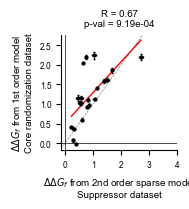

In [9]:
weights_merger = firstorderterms[['suppressor_ddGs','suppressor_ddGs_std']].merge(coefs_1storder[['actual_ddGs','scaled_std']], left_index=True, right_index=True)

from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score

weights_merger=weights_merger.sort_values('suppressor_ddGs')

x = weights_merger[['suppressor_ddGs']].to_numpy()
y = weights_merger[['actual_ddGs']].to_numpy()

model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r2 = r2_score(y,y_pred)
r,p = pearsonr(y.ravel(),y_pred.ravel())

fig, ax=plt.subplots(figsize=(1.5,1.5))
ax.axline((0, 0), slope=1, linestyle="dashed", color='gray', lw=0.5)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
plt.plot(x, y_pred, color='red', linewidth=1, linestyle='-')
ax.errorbar(weights_merger[['suppressor_ddGs']].to_numpy().ravel(),weights_merger[['actual_ddGs']].to_numpy().ravel(),weights_merger[['scaled_std']].to_numpy().ravel(),weights_merger[['suppressor_ddGs_std']].to_numpy().ravel(), color='k',linewidth=0,
           markersize=2,marker='o', capsize=0.5, elinewidth=0.5)
ax.set_xlabel(r'${ΔΔG_{f}}$ from 2nd order sparse model'+'\nSuppressor dataset', fontsize=7)
ax.set_ylabel(r'${ΔΔG_{f}}$ from 1st order model'+'\nCore randomization dataset', fontsize=7)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(labelsize=6)
ax.set_xticks(np.arange(0,5,1))
#ax.set_xticklabels(np.arange(0,4,1))
plt.title('R = '+str(round(r,2))+ '\np-val = '+'{:0.2e}'.format(p), fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Suppressor_vs_1stordercore_model_1storderterms.svg', dpi=300, transparent=True)


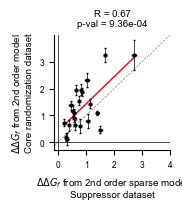

In [10]:
weights_merger = firstorderterms[['suppressor_ddGs','suppressor_ddGs_std']].merge(coefs_2ndorder[['actual_ddGs','scaled_std']], left_index=True, right_index=True)

from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score

weights_merger=weights_merger.sort_values('suppressor_ddGs')

x = weights_merger[['suppressor_ddGs']].to_numpy()
y = weights_merger[['actual_ddGs']].to_numpy()

model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r2 = r2_score(y,y_pred)
r,p = pearsonr(y.ravel(),y_pred.ravel())

fig, ax=plt.subplots(figsize=(1.5,1.5))
ax.axline((0, 0), slope=1, linestyle="dashed", color='gray', lw=0.5)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
plt.plot(x, y_pred, color='red', linewidth=1, linestyle='-')
ax.errorbar(weights_merger[['suppressor_ddGs']].to_numpy().ravel(),weights_merger[['actual_ddGs']].to_numpy().ravel(),weights_merger[['scaled_std']].to_numpy().ravel(),weights_merger[['suppressor_ddGs_std']].to_numpy().ravel(), color='k',linewidth=0,
           markersize=2,marker='o', capsize=0.5, elinewidth=0.5)
ax.set_xlabel(r'${ΔΔG_{f}}$ from 2nd order sparse model'+'\nSuppressor dataset', fontsize=7)
ax.set_ylabel(r'${ΔΔG_{f}}$ from 2nd order model'+'\nCore randomization dataset', fontsize=7)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(labelsize=6)
ax.set_xticks(np.arange(0,5,1))
#ax.set_xticklabels(np.arange(0,4,1))
plt.title('R = '+str(round(r,2))+ '\np-val = '+'{:0.2e}'.format(p), fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Suppressor_vs_2ndordercore_model_1storderterms.svg', dpi=300, transparent=True)


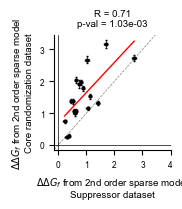

In [11]:
weights_merger = firstorderterms[['suppressor_ddGs','suppressor_ddGs_std']].merge(coefs_2ndorder_sprsreg[['actual_ddGs','scaled_std']], left_index=True, right_index=True)

from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score

weights_merger=weights_merger.sort_values('suppressor_ddGs')

x = weights_merger[['suppressor_ddGs']].to_numpy()
y = weights_merger[['actual_ddGs']].to_numpy()

model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r2 = r2_score(y,y_pred)
r,p = pearsonr(y.ravel(),y_pred.ravel())

fig, ax=plt.subplots(figsize=(1.5,1.5))
ax.axline((0, 0), slope=1, linestyle="dashed", color='gray', lw=0.5)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
plt.plot(x, y_pred, color='red', linewidth=1, linestyle='-')
ax.errorbar(weights_merger[['suppressor_ddGs']].to_numpy().ravel(),weights_merger[['actual_ddGs']].to_numpy().ravel(),weights_merger[['scaled_std']].to_numpy().ravel(),weights_merger[['suppressor_ddGs_std']].to_numpy().ravel(), color='k',linewidth=0,
           markersize=2,marker='o', capsize=0.5, elinewidth=0.5)
ax.set_xlabel(r'${ΔΔG_{f}}$ from 2nd order sparse model'+'\nSuppressor dataset', fontsize=7)
ax.set_ylabel(r'${ΔΔG_{f}}$ from 2nd order sparse model'+'\nCore randomization dataset', fontsize=7)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(labelsize=6)
ax.set_xticks(np.arange(0,5,1))
#ax.set_xticklabels(np.arange(0,4,1))
plt.title('R = '+str(round(r,2))+ '\np-val = '+'{:0.2e}'.format(p), fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Suppressor_vs_2ndordersprsregcore_model_1storderterms.svg', dpi=300, transparent=True)
